In [1]:
%matplotlib inline
import matplotlib.pyplot as plt 
import numpy as np
import tensorflow as tf
import keras
import keras.backend as kb
import logomaker
import pandas as pd

Using TensorFlow backend.
/Users/alicegao/anaconda2/envs/dg_work/lib/python2.7/site-packages/logomaker/src/Logo.py:10: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/alicegao/anaconda2/envs/dg_work/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/Users/alicegao/anaconda2/envs/dg_work/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/Users/alicegao/anaconda2/envs/dg_work/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/alicegao/anaconda2/envs/dg_work/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instan

In [2]:
model = keras.models.load_model('input_data/model.hdf5', custom_objects={'kb': kb})

In [3]:
DNA_ENCODING = np.asarray([[0, 0, 0, 0],
                           [1, 0, 0, 0],
                           [0, 1, 0, 0],
                           [0, 0, 1, 0],
                           [0, 0, 0, 1]])

In [4]:
# def encode_seq(seq):
#     def _encode_seq(seq):
#         seq = seq.upper().replace('A', '1').replace('C', '2').replace('G', '3').replace('T', '4').replace('U', '4').replace('N', '0')
#         x = np.asarray(map(int, list(seq)))
#         x = DNA_ENCODING[x.astype('int8')]
#         return x
#     seq_rev = seq[::-1]
#     x1 = _encode_seq(seq)
#     x2 = _encode_seq(seq_rev)
#     return x1, x2


def encode_seq(seq):
    def _encode_seq(seq):
        seq = seq.upper().replace('A', '1').replace('C', '2').replace('G', '3').replace('T', '4').replace('U', '4').replace('N', '0')
        x = np.asarray(map(int, list(seq)))
        x = DNA_ENCODING[x.astype('int8')]
        return x
    return _encode_seq(seq)


In [5]:
def w_to_df(w):
    assert len(w.shape) == 2
    assert w.shape[1] == 4
    data = []
    for i in range(w.shape[0]):
        data.append({
            'A': w[i, 0],
            'C': w[i, 1],
            'G': w[i, 2],
            'U': w[i, 3],
        })
    return pd.DataFrame(data)

In [6]:
# test seq
seq_org = 'GAAUGGGUUAAAAGGGGGGCGCAUUGGUACCUGCUAUUAGGGAUCAAUCGG'


In [7]:
# current output
x1 = encode_seq(seq_org)
x1 = x1[np.newaxis, :, :]
pred_org = model.predict(x1)[0, :, 0]

In [8]:
print pred_org.max(), pred_org.argmax()

0.8383031 44


In [9]:
# test idx - make sure to pick one that makes sense!
new_idx = 10
assert new_idx != pred_org.argmax()
print pred_org[new_idx], new_idx

3.9591327e-05 10


In [10]:
layer_output = model.layers[-1].output

In [11]:
loss = kb.mean(layer_output[:,new_idx, :])

In [12]:

input_node = model.layers[0].input

In [13]:
print input_node

Tensor("input_org:0", shape=(?, 51, 4), dtype=float32)


In [14]:

grads = kb.gradients(loss, input_node)[0]

In [15]:
grads /= (kb.sqrt(kb.mean(kb.square(grads))) + 1e-5)

In [16]:
iterate = kb.function([input_node], [loss, grads])

/Users/alicegao/anaconda2/envs/dg_work/lib/python2.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


7.2055416e-05
7.568706e-05
7.984246e-05
8.4606996e-05
9.009514e-05
9.646232e-05
0.00010392494
0.00011277673
0.00012313822
0.00013512027
0.00014947352
0.00016702646
0.00018835657
0.00021467842
0.0002475513
0.00028820333
0.00033899027
0.00040174273
0.0004841409
0.00059204234
0.0007368367
0.0009381111
0.0012283238
0.0016759576
0.0023361093
0.003424539
0.0052180365
0.00804703
0.01271548
0.020166894
0.033016942
0.0514923
0.07322007
0.082444996
0.08768358
0.09329443
0.09742209
0.10012343
0.1029672
0.10577021
0.10871109
0.11178124
0.11524467
0.118771285
0.12234388
0.12637712
0.13065739
0.1354731
0.14051624
0.14572841
0.15108946
0.15666498
0.16300671
0.16981779
0.17784192
0.18809721
0.20153943
0.21666463
0.23257302
0.24920443
0.26884347
0.29119202
0.31618312
0.34199187
0.37172186
0.4028638
0.43120587
0.45398128
0.4715892
0.48959476
0.5078678
0.5245394
0.5407414
0.55518764
0.5691851
0.58265877
0.5935538
0.6034792
0.6115955
0.61846554
0.62452954
0.6304358
0.63554305
0.6402539
0.64498353
0.650396

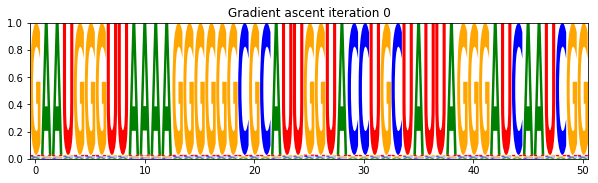

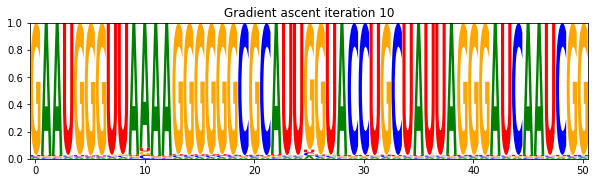

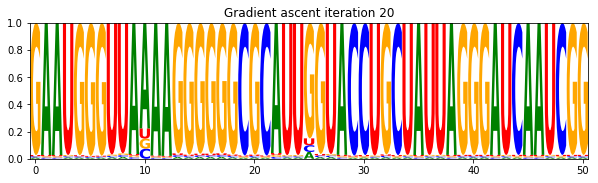

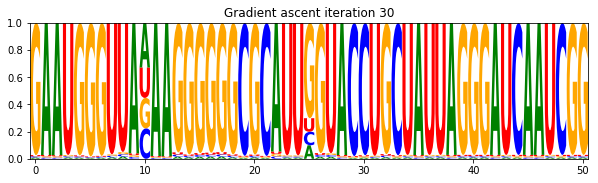

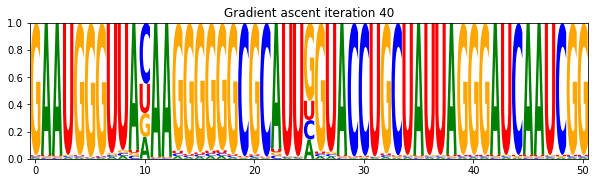

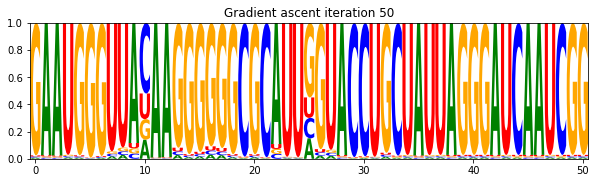

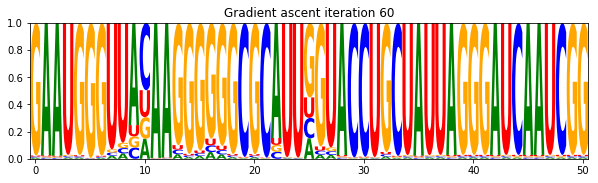

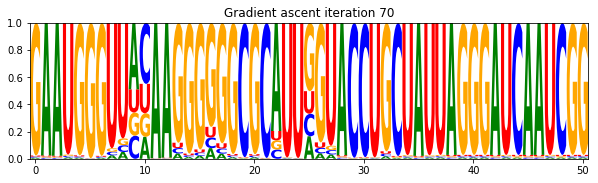

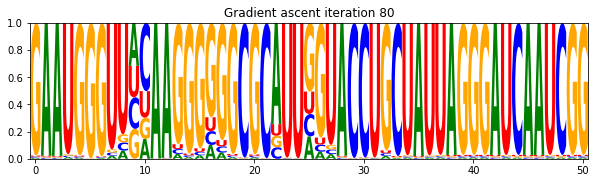

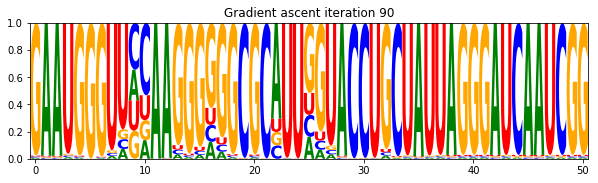

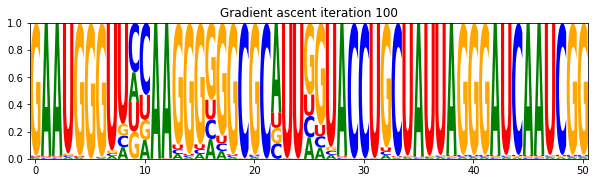

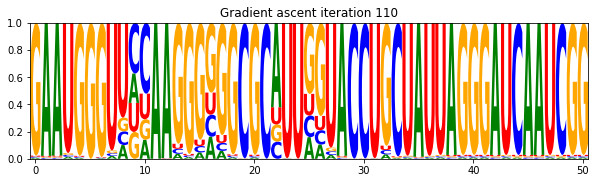

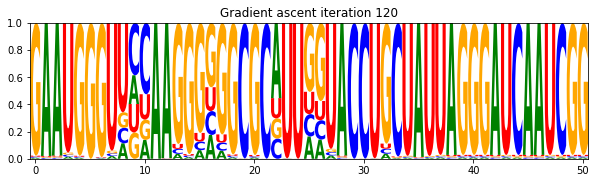

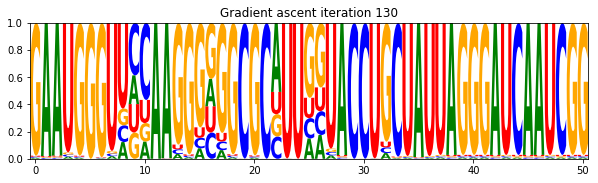

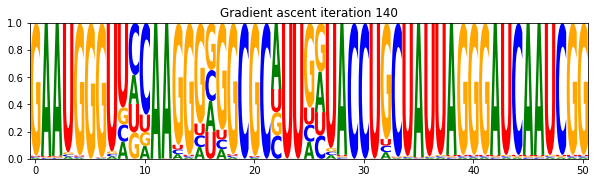

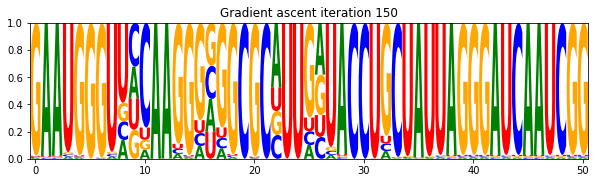

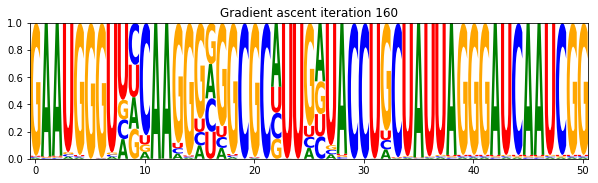

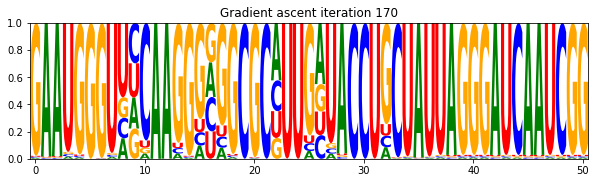

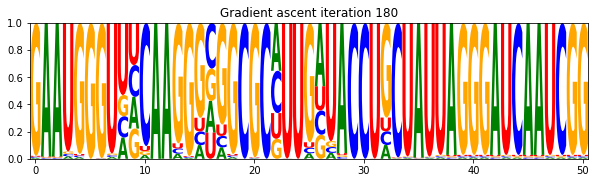

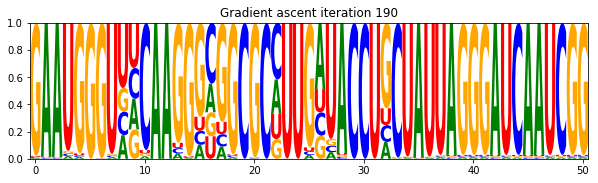

In [17]:
# we start from a gray image with some noise
x1_new = x1.astype(np.float32)
# add a little bit noise
x1_new += 1e-2
# normalize
x1_new = x1_new/np.sum(x1_new, axis=-1)[:, :, np.newaxis]
# run gradient ascent
for i in range(200):
    loss_value, grads_value = iterate([x1_new])
    x1_new += grads_value * 0.01
    # re-normalize
    x1_new = x1_new/np.sum(x1_new, axis=-1)[:, :, np.newaxis]
#     print x1_new

    # plot every 10 iteration
    if i % 10 == 0:
        df = w_to_df(x1_new[0, :, :])
        filter_logo = logomaker.Logo(df)
        filter_logo.ax.set_title("Gradient ascent iteration {}".format(i))
        filter_logo.fig.show()

    pred_new = model.predict(x1_new)[0, :, 0]
    print pred_new[new_idx]

In [26]:
# TODO after gradient ascent, take argmax -> new sequence
# check prediction
# run RNAfold look at structure
nt_dict = ['A', 'C', 'G', 'U']
seq_new = []
for i in range(x1_new.shape[1]):
    seq_new.append(nt_dict[np.argmax(x1_new[0, i, :])])
seq_new = ''.join(seq_new)
print seq_new


_x1 = encode_seq(seq_new)
_x1 = _x1[np.newaxis, :, :]
_pred = model.predict(_x1)[0, :, 0]

print np.argmax(_pred), np.max(_pred)
print _pred[new_idx]

GAAUGGGUUUCAAGGGCGGCGCCUUGAUACCUGCUAUUAGGGAUCAAUCGG
10 0.94935983
0.94935983


In [27]:
seq_org

'GAAUGGGUUAAAAGGGGGGCGCAUUGGUACCUGCUAUUAGGGAUCAAUCGG'

In [28]:
seq_new

'GAAUGGGUUUCAAGGGCGGCGCCUUGAUACCUGCUAUUAGGGAUCAAUCGG'

In [18]:
grads_value[0, :5, :]

array([[ 0.        ,  0.        , -0.07514685,  0.        ],
       [ 0.45510265,  0.        ,  0.        ,  0.        ],
       [ 1.623643  ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , -0.37146872],
       [ 0.        ,  0.        , -0.65534866,  0.        ]],
      dtype=float32)

In [19]:
x1_new[:, :5, :]

array([[[0.00731592, 0.00731592, 0.9780522 , 0.00731592],
        [0.9851463 , 0.00495122, 0.00495122, 0.00495122],
        [0.98740745, 0.00419751, 0.00419751, 0.00419751],
        [0.02021843, 0.02021843, 0.02021843, 0.9393447 ],
        [0.01458196, 0.01458196, 0.9562541 , 0.01458196]]], dtype=float32)

In [20]:
# TODO normalize so input makes sense?

In [21]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_org (InputLayer)          (None, 51, 4)        0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 51, 4)        0           input_org[0][0]                  
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 51, 4)        16          lambda_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 51, 4)        16          input_org[0][0]                  
__________________________________________________________________________________________________
activation